<img src='../OUTILS/bandeau_MF.png' align='right' width='100%'/>

<div class="alert alert-info alert-success">
<h3>Elaboration de la RGB Dust - FCI /MTG </h3></div>

## <a id='TOC-TOP'></a>Contenus

<div class="alert alert-block alert-warning">
    
<b>PREREQUIS </b>
    
Ce Notebook ne nécessite pas de prérequis

</div>
<hr>

<div class="alert alert-info" role="alert">

## <a id='section1'></a>1.Tout d'abord, il faut procéder à l'importation des librairies nécessaires.

</div>

In [ ]:
from PIL import Image
from IPython.display import display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import scipy
import os
#os.environ['PATH'] = f"/opt/conda/envs/casablanca/bin:{os.environ['PATH']}"

### Données d'entrée et de sortie :

In [ ]:
download_dir = os.path.join(os.getcwd(), "../RESULTATS")
os.makedirs(download_dir, exist_ok=True)

In [ ]:
input = '../../MF_DATA/MTG/MTG_multic/Multic2km_mtgi1_20231122_140000.nc'
output = '../RESULTATS/'

In [ ]:
!gdalinfo {input}

In [ ]:
!gdalinfo -mm NETCDF:"../../MF_DATA/MTG/MTG_multic/Multic2km_mtgi1_20231122_140000.nc":VIS006

In [ ]:
!pwd

In [ ]:
!gdal_translate -ot byte -scale 0 2000 0 255 NETCDF:"../../MF_DATA/MTG/MTG_multic/Multic2km_mtgi1_20231122_140000.nc":VIS006 {output}VIS006.tif

In [ ]:
!convert -resize 300x300 {output}VIS006.tif {output}VIS006.jpg

In [ ]:
im = Image.open(output + 'VIS006.jpg', 'r')
display(im)

### dossier de sortie :

### Extraction des données dans le NetCDF

<div class="alert alert-info" role="alert">

## <a id='section2'></a>2.Extraction des données dans le NetCDF
[Back to top](#TOC-TOP)

</div>


Pour rappel, la recette de la RGB Dust est la suivante :

<img src='../OUTILS/dust_tableau.png' align='right' width='100%'/>

Red: IR12.3 – IR10.5, range -4 to +2 K, Gamma = 1.0

Green: IR10.5 – IR8.7, Range 0 to +15 K, Gamma = 2.5

Blue: IR10.5, range 261 to 289 K, Gamma = 1.0

Extraction des données des trois longueurs d'ondes nécessaires aux calculs des différences :

In [ ]:
!gdal_translate NETCDF:"$input":IR_105 {output}/105.tif
!gdal_translate NETCDF:"$input":IR_123 {output}/123.tif
!gdal_translate NETCDF:"$input":IR_087 {output}/087.tif

Extraction des données IR 10.8 pour la bande bleue.
Les valeurs 261 et 289 K correspondent à -12,15 °C et 15,85 °C
Dans le NetCDF, les données sont en centième de °C.

In [ ]:
#!gdalinfo  NETCDF:"$input":IR_105

In [ ]:
!gdal_translate -ot byte -scale -1215 1585 0 255 NETCDF:"$input":IR_105 {output}/105_-1215_1585.tif

In [ ]:
!gdal_translate -ot byte -scale 5000 -8000 0 255 NETCDF:"$input":IR_105 {output}/105_5000_-8000.tif

In [ ]:
!convert -resize 500x500 {output}/105_-1215_1585.tif {output}105_-1215_1585.jpg 2>/dev/null
!convert -resize 500x500 {output}/105_5000_-8000.tif {output}/105_5000_-8000.jpg 2>/dev/null

In [ ]:
#im_a = Image.open(output + '/105_-1215_1585.jpg', 'r')
#display(im)

In [ ]:
#im_b = Image.open(output + '/105_5000_-8000.jpg', 'r')
#display(im2)

#### Affichage des images 105_-1215_1585.jpg et 105_5000_-8000.jpg

In [ ]:
!ls ../RESULTATS/105_-1215_1585.jpg

<div style="display: flex; justify-content: center; align-items: center;">
<img src='../RESULTATS/105_-1215_1585.jpg' align='left' width='310px'  />
<img src='../RESULTATS/105_5000_-8000.jpg' align='right' width='310px' />
</div>

(en cas de bug d'affichage des images ci-dessus, double cliquer sur le bloc, et modifier la largeur en px)

### Calcul des différences

In [ ]:
!gdal_calc.py  -A {output}/123.tif -B {output}/105.tif --outfile={output}/123_105.tif --calc="A-B"
!gdal_calc.py  -A {output}/105.tif -B {output}/087.tif --outfile={output}/105_087.tif --calc="A-B"

On met les différences sur les échelles -4-2 pour le rouge et 0-15 pour le vert.
Une différence en Kelvin et égale à une différence en °C.

In [ ]:
!gdal_translate -ot byte -scale -400 200 0 255 {output}/123_105.tif {output}/123_105_scale.tif
!gdal_translate -ot byte -scale 0 1500 0 255 {output}/105_087.tif {output}/105_087_scale.tif

In [ ]:
!convert -resize 500x500 {output}/123_105_scale.tif {output}/123_105_scale.jpg 2>/dev/null
!convert -resize 500x500 {output}/105_087_scale.tif {output}/105_087_scale.jpg 2>/dev/null

In [ ]:
#### Affichage des images 123_105_scale.jpg et 105_087_scale.jpg

<div style="display: flex; justify-content: center; align-items: center;">
<img src='../RESULTATS/123_105_scale.jpg' align='left' width='310px'  />
<img src='../RESULTATS/105_087_scale.jpg' align='right' width='310px' />
</div>        

### Calcul de la correction gamma avec gdal_calc.py :

Pour rappel la formule de la correction gamme est :

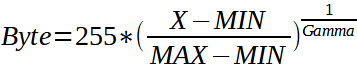


(Note : imagemagick permet de faire une correction gamma mais n'est pas compatible avec Windows)

La première étape consiste à extraire les valeurs min et max de l'image.

In [ ]:
!convert -gamma 2.5 {output}/105_087_scale.tif {output}/105_087_scale_gamma.tif 2>/dev/null

In [ ]:
file_in = '../RESULTATS/105_087_scale.tif'
imgpil = Image.open(file_in)  
img = np.array(imgpil)
max = np.max(img)
min = np.min(img)

Ensuite on calcule et on applique la correction gamma pour une valeur de 2,5 :

In [ ]:
gamma= 2.5

In [ ]:
!gdal_calc.py --quiet --NoDataValue 0 --overwrite -A {file_in} --calc="numpy.maximum(A*0.,{max}*((A-{0}.)/({255}-{0}))**(1/{gamma}))" --outfile {output}/105_087_scale_gamma-std.tif

In [ ]:
!gdal_calc.py --quiet --NoDataValue 0 --overwrite -A {file_in} --calc="numpy.maximum(A*0.,{max}*((A-{min}.)/({max}-{min}))**(1/{gamma}))" --outfile {output}/105_087_scale_gamma.tif

In [ ]:
#Gamma = 1 (Pour comparaison)
!gdal_calc.py --quiet --NoDataValue 0 --overwrite -A {file_in} --calc="numpy.maximum(A*0.,{max}*((A-{min}.)/({max}-{min}))**(1/{1}))" --outfile {output}/105_087_scale_gamma_1.tif

In [ ]:
max, min

In [ ]:
!convert -resize 500x500 {output}/105_087_scale_gamma-std.tif {output}/105_087_scale_gamma-std.jpg 2>/dev/null
!convert -resize 500x500 {output}/105_087_scale_gamma.tif {output}/105_087_scale_gamma.jpg 2>/dev/null
!convert -resize 500x500 {output}/105_087_scale_gamma_1.tif {output}/105_087_scale_gamma_1.jpg 2>/dev/null

#### Affichage des images 105_087_scale_gamma-std.jpg, 105_087_scale_gamma.jpg et 105_087_scale_gamma_1.jpg

<div style="display: flex; justify-content: center; align-items: center;">
<img src='../RESULTATS/105_087_scale_gamma-std.jpg' align='left' width='30%'  />
<img src='../RESULTATS/105_087_scale_gamma.jpg' align='right' width='30%' />
<img src='../RESULTATS/105_087_scale_gamma_1.jpg' align='right' width='30%' />
</div>  

<div class="alert alert-info" role="alert">

## <a id='section3'></a>3.Fabrication de la RGB
[Back to top](#TOC-TOP)

</div>

In [ ]:
!gdal_merge.py -separate {output}/123_105_scale.tif {output}/105_087_scale_gamma.tif {output}/105_-1215_1585.tif -o {output}/RGB_dust.tif
!convert -resize 700x700 {output}/RGB_dust.tif {output}/RGB_dust.jpg 2>/dev/null

### Visualisation du résultat

In [ ]:
im = Image.open(output + '/RGB_dust.jpg', 'r')
display(im)

In [ ]:
#Nettoyage
!rm {output}/VIS006.tif {output}/123.tif {output}/*.tif